# Scachepy - caching extension for Scanpy

This notebook shows the usage of Scachepy - a caching extension for Scanpy. What is does is basically pickles the result of an operation that takes too long to compute (or is required to be reproducible).

Here are all the functions which have caching version implemented. Future improvements will most likely include the support for `.h5ad` as a backend (currently, only `pickle` backend is available).

In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import scanpy as sc
import scvelo as scv
import scachepy 
import tempfile

# Data loading and cache creation

In [36]:
handle = tempfile.TemporaryDirectory()
c = scachepy.Cache(handle.name, backend='pickle', separate_dirs=True)
c

Cache(root=/tmp/tmpgop9qcme, ext='.pickle')

By specifying `separate_dirs=True`, the cache will create `pp`, `tl` and `pl` subdirectories under the root directory.

In [37]:
adata = sc.datasets.paul15()
adata.var_names_make_unique()

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, making a copy.


# Usage principles

In [38]:
c.pp.pca(adata, force=False, verbose=True)

No cache found in `pca.pickle`, computing values.


No cache found in `pca_plot.pickle`, computing values.


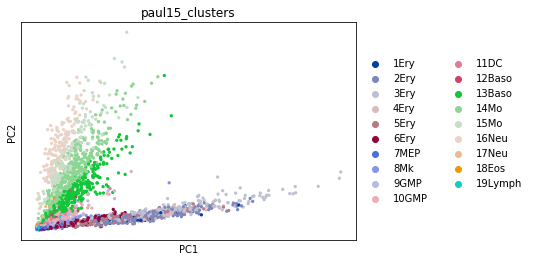

In [39]:
c.pl.pca(adata, color='paul15_clusters')

Loading data from: `pca_plot.pickle`.


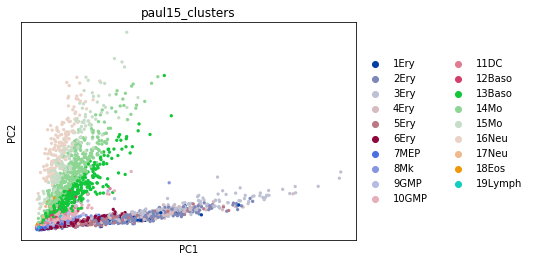

In [40]:
c.pl.pca(adata, color='paul15_clusters')

## c.pp.pcarr

Difference between the `c.pp.pca` and `c.pp.pcarr` is that the former operates on `anndata.AnnData`, whereas the latter takes `np.ndarray` and caches only the `X_pca` attribute of `obsm`.

In [41]:
_ = c.pp.pcarr(adata.X)
_.shape

No cache found in `pca_arr.pickle`, computing values.


(2730, 50)

## Extra arguments

Each functions has some useful arguments:
+ `fname=...` - overrides the default filename
+ `force=...` - whether to force recaching (default: `False`)
+ `skip=...` - whether to skip not optional keys if not found (default: `False`)
+ `call=...` - whether to call the callback or not (default: `True`)
+ `copy=...` - whether to create/operate on copy or not, works also during loading (default: `False`)
+ `verbose=...` - be verbose (default: `True`)

In [42]:
c.pp.neighbors(adata, force=True, fname='foo', verbose=False)

We also need to specify the used `fname` to load it back again.

In [43]:
c.pp.neighbors(adata, fname='foo')

Loading data from: `foo.pickle`.


## Copy argument

These functions also work with `copy=True`, where applicable.

In [44]:
assert 'louvain' not in adata.uns

In [45]:
adata_louvain = c.tl.louvain(adata, copy=True)

No cache found in `louvain.pickle`, computing values.


In [46]:
assert 'louvain' not in adata.uns
assert 'louvain' in adata_louvain.uns

## Default functions

Caching functions usually cache the values based on their default function (and the keys specified). However, they can be used more flexibly, such as using a custom function (note that this example is just a silly demonstration):

In [47]:
def test(adata, *args, **kwargs):
    print('Look Ma, no hands!')
    return sc.pp.log1p(adata)

By default, `c.pp.expression` has no default function, but we can easily change that (the function needs to be supplied as the first argument, even before the `adata` object).

In [48]:
adata.X

array([[0., 0., 0., ..., 0., 2., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [1., 0., 3., ..., 2., 3., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [3., 0., 3., ..., 0., 1., 0.],
       [0., 0., 4., ..., 1., 1., 1.]], dtype=float32)

In [49]:
c.pp.expression(test, adata, force=True, fname='test')

Computing values (forced).
Look Ma, no hands!


In [50]:
c.pp.expression(adata, fname='test')

Loading data from: `test.pickle`.


The values have changed as expected. `anndata.Anndata` objects is either the first one in `args` or under key `adata` in `kwargs`.

In [51]:
adata.X

array([[0.       , 0.       , 0.       , ..., 0.       , 1.0986123,
        0.       ],
       [0.       , 0.       , 0.6931472, ..., 0.       , 0.6931472,
        0.       ],
       [0.6931472, 0.       , 1.3862944, ..., 1.0986123, 1.3862944,
        0.       ],
       ...,
       [0.       , 0.       , 0.6931472, ..., 0.       , 0.       ,
        0.       ],
       [1.3862944, 0.       , 1.3862944, ..., 0.       , 0.6931472,
        0.       ],
       [0.       , 0.       , 1.609438 , ..., 0.6931472, 0.6931472,
        0.6931472]], dtype=float32)

In [52]:
!ls $c.backend.dir

ls: cannot access '.backend.dir': No such file or directory


# Implemented caching functions

In [53]:
list(c.pp)

['pcarr', 'expression', 'moments', 'pca', 'neighbors']

In [54]:
list(c.tl)

['louvain',
 'tsne',
 'umap',
 'diffmap',
 'paga',
 'velocity',
 'velocity_graph',
 'velocity_embedding',
 'draw_graph']

Fair warning, plotting caching functions have not been tested yet.

In [55]:
list(c.pl)

['clustermap',
 'correlation_matrix',
 'dendrogram',
 'diffmap',
 'dotplot',
 'dpt_groups_pseudotime',
 'dpt_timeseries',
 'draw_graph',
 'embedding_density',
 'filter_genes_dispersion',
 'heatmap',
 'highest_expr_genes',
 'highly_variable_genes',
 'matrix',
 'matrixplot',
 'paga',
 'paga_adjacency',
 'paga_compare',
 'paga_path',
 'pca',
 'pca_loadings',
 'pca_variance_ratio',
 'rank_genes_groups',
 'rank_genes_groups_dotplot',
 'rank_genes_groups_heatmap',
 'rank_genes_groups_matrixplot',
 'rank_genes_groups_stacked_violin',
 'rank_genes_groups_tracksplot',
 'rank_genes_groups_violin',
 'scatter',
 'sim',
 'stacked_violin',
 'tracksplot',
 'tsne',
 'umap',
 'violin']

## Creating your own caching functions

Creating new functions is relatively simple, as seen below. Note that `_cache1` is only present because `dict` needs to have unique keys, it gets stripped down down the line (it can be specified in other ways too, but this is the most convenient one). The `_opt` postfix indicates that this is optional attribute to cache - if it's not found, it will not complain (mandatory ones can be always skipped with `skip=True`).

Below is the exact implementation of `c.pp.moments`.

In [56]:
c.pp.foo = c.pp.cache(dict(uns_opt='pca',
                           uns_opt_cache1='neighbors',
                           obsm_opt='X_pca',
                           varm_opt='PCs',
                           layers='Ms',
                           layers_cache1='Mu'),
                      default_fn=scv.pp.moments,
                      default_fname='moments')
c.pp.foo

<caching function of "scvelo.preprocessing.moments.moments">

### Testing out the function

In [57]:
adata.layers['spliced'] = adata.X
adata.layers['unspliced'] = adata.X / 2

The below function will throw error, unless we specify `skip=True`, because `.layers['Ms']` is not optional.

In [58]:
def callback(adata, *args, **kwargs):
    scv.pp.moments(adata)
    adata.obsm.pop('X_pca', None)
    adata.layers.pop('Ms', None)

try:
    c.pp.foo(callback, adata, skip=False)
except AssertionError:
    print('Assertion error, as expected.')

No cache found in `moments.pickle`, computing values.
computing neighbors
    finished (0:00:00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
Traceback (most recent call last):
  File "/opt/projects/scachepy/scachepy/backends.py", line 130, in _get_val
    obj = obj[k]
  File "/home/michal/.local/miniconda3/envs/reprog/lib/python3.6/site-packages/anndata/core/alignedmapping.py", line 159, in __getitem__
    return self._data[key]
KeyError: 'Ms'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/opt/projects/scachepy/scachepy/modules.py", line 73, in wrapper
    possible_vals=possible_vals, verbose=verbose)
  File "/opt/projects/scachepy/scachepy/backends.py", line 182, in save
    value = _get_val(

In [59]:
c.pp.foo(callback, adata, skip=True)

No cache found in `moments.pickle`, computing values.
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)


# Changing directories

In [60]:
!ls $c.root_dir/pp

foo.pickle  moments.pickle  pca_arr.pickle  pca.pickle	test.pickle


In [61]:
c.pp.backend.dir = 'bar'
c.pp.pca(adata, fname='test')

No cache found in `test.pickle`, computing values.


If `separate_dirs=False`, this also changes the directory for other modules, since the backend is shared (not our case).

In [62]:
c.tl.backend.dir

PosixPath('/tmp/tmpgop9qcme/tl')

In [63]:
c.pp.pca(adata, fname='test')

Loading data from: `test.pickle`.


In [64]:
!ls $c.root_dir/bar

test.pickle


# Clearing

If using `separate_dirs=True` options (note: **NOT** default because of backwards compatibility), you can clear `pp`, `tl` or `pl` separately.

If using `separate_dirs=False`, this is the same as `c.clear()`, which just deletes everything.

Default verbosity is `1`, which just prints how many files are removed.

In [65]:
c.tl.clear()

Deleting 1 files from `tl`.


In [66]:
c.clear(verbose=2)

Deleting 1 files from `pp`.
Deleting `test.pickle`.
--------
Deleting 0 files from `tl`.
--------
Deleting 1 files from `pl`.
Deleting `pca_plot.pickle`.
